# Resnet50 ile InceptionV3 Modelleri Kullanarak Yabani ve Diğer Otlar Veri Setiyle Karşılaştırılması

## Veri Önişleme
Veri setine ulaşabilmek için Google Drive ile projemizi bağlıyoruz.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Eğitim sırasında kesintiye uğramaması için kullanılan Javascript Kodu
# function ClickConnect(){
# console.log("Working"); 
# document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
# }
# var clicker = setInterval(ClickConnect,60000);

# kapatmak için clearInterval(clicker)

# komutu kullanılmaktadır.

## Arşivden Çıkarma
Drive içerisinde belirtmiş olduğumuz veri setinin içerisindeki zip dosyasını açmak için kullanılmaktadır. Veri seti önceden arşivden çıkarıldığı için yorum satırı olarak verilmiştir.

In [ ]:
# !unzip /content/drive/MyDrive/DATASETS/WeedDatasets/images.zip -d /content/drive/MyDrive/DATASETS/WeedDatasets/images/

## Dosya Konumlarının Belirlenmesi ve Ön Ayarlar

Projemizde verdiğimiz veri setinin konumunu ve sınıfların bulunduğu dosyanın dizinlerini veriyoruz.



In [ ]:
import os

# DOSYA YOLLARI
PROJECT_PATH = os.getcwd()
DATASETS_FOLDER = os.path.join(PROJECT_PATH,'drive','MyDrive','DATASETS')
DATASET_FOLDER = os.path.join(DATASETS_FOLDER,'WeedDatasets')
IMAGES_PATH = os.path.join(DATASET_FOLDER,'images')
# GLOB_IMAGE_PATH = os.path.join(IMAGES_PATH,'*.jpg')
# Glob kütüphanesi ile kullanılırsa bütün resimlerin dizinini alır
LABEL_PATH = os.path.join(DATASET_FOLDER,'labels.csv')



Alttaki kod satırında ise aktif bir ekran kartının bulunup bulunmadığını öğreniyoruz. Eğer yoksa proje hata verecektir.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Verilerin Ön İşlenmesi ve Artırımı


Verilerin işlenmesi ve artırımı bu aşamada yapılmaktadır.


### Ön İşleme

```
20160928-140314-0.jpg	0	Chinee apple
20160928-140337-0.jpg	0	Chinee apple
20160928-140731-0.jpg	0	Chinee apple
20160928-140747-0.jpg	0	Chinee apple
...
```
Veriler üstteki gibi bir csv dosyası içerisinde dosya adı, etiket ve etiketin değeriyle birlikte verilmiştir. Verilen veriyi Pandas kütüphanesi yardımıyla bir veri seti oluşturduktan sonra shuffle yardımıyla içerisinde karıştırırız. Sonrasında Colab'ın vermiş olduğu 12GB RAM sınırından dolayı 17504 tane 256x256 görsel bulunduran veri setinden yalnız 2500 adet alabilmekteyiz. Bu sebepten dolayı veri setini karıştırıyoruz.

Karıştırdıktan sonra dosya isimlerini alıyoruz ve bir döngü içerisinde verdiğimiz dosya konumu içerisindeki görsellerle birlikte o dosyanın indisini alarak etiket verisine ulaşıyoruz.

Bu verilerden etiketi kategorize olarak ayırmamız gerekmektedir. Sebebi ise 8 değerinde bir etiketi bilgisayar anlamayacaktır ve bunu Sklearn OneHotEncoding ya da Keras utils içerisindeki to_categorical metoduyla anlayacağı biçimde [0,0,0,0,0,0,0,0,1] şeklinde değiştirmektedir ve eklemektedir. Görseller olduğu gibi eklemekteyiz.

Sonuç olarak kaç tane veri aldığını ve bunun boyutlarını yazdırmaktadır.


Label Length     - 2500
Classes Length   - 2500
Filenames Length - 2500
Num of Classes   - 9



0it [00:00, ?it/s]


Siam weed


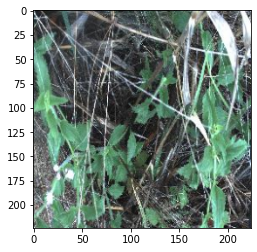

1it [01:10, 70.98s/it]


Rubber vine


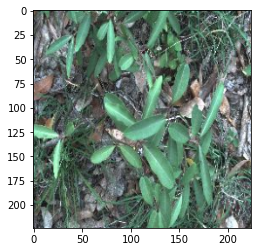

2it [01:11, 29.52s/it]


Negative


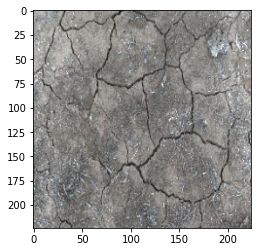

13it [01:16,  1.41it/s]


Snake weed


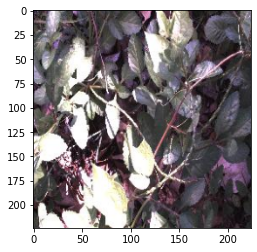

22it [01:20,  2.19it/s]


Chinee apple


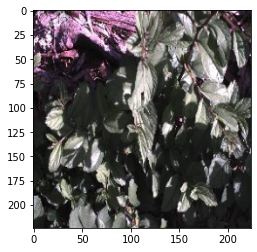

23it [01:20,  2.14it/s]


Prickly acacia


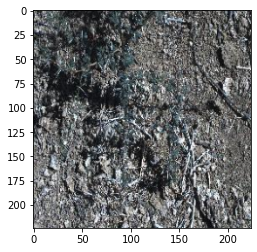

25it [01:21,  2.29it/s]


Parthenium


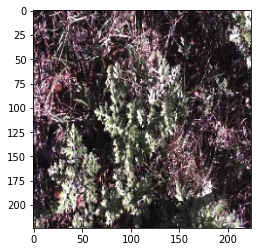

33it [01:24,  2.63it/s]


Parkinsonia


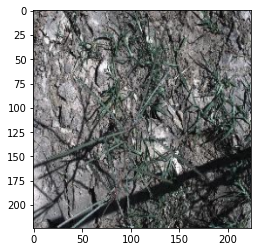

47it [01:30,  2.63it/s]


Lantana


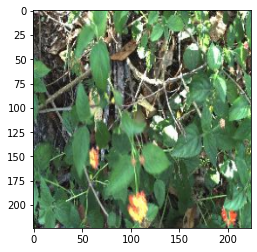

2500it [17:04,  2.44it/s]


Resim Boyutları  :  (2500, 224, 224, 3)
Tabela Boyutları :  (2500, 9)



In [ ]:
from tqdm import tqdm # progress bar

import pandas as pd
import cv2
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# CONSTS DEĞİŞKENLER
IMAGE_SIZE = (224,224)
IMAGE_TENSOR_SIZE = (IMAGE_SIZE[0],IMAGE_SIZE[1],3)
dict_classes = {
    0:"Chinee apple",
    1:"Lantana",
    2:"Parkinsonia",
    3:"Parthenium",
    4:"Prickly acacia",
    5:"Rubber vine",
    6:"Siam weed",
    7:"Snake weed",
    8:"Negative"
}

# Datasetin Alınması ve karıştırma işlemi
dataset = pd.read_csv(LABEL_PATH)
dataset = shuffle(dataset)

# Alınacak Veri Sayısı (RAM sorunundan dolayı kısıtlanmıştır.)
GET_ITEM = 2500

# Datasetten önemli veriler alınır.
labels = dataset['Label'][:GET_ITEM]
filenames = dataset['Filename'][:GET_ITEM]
classes = dataset['Species'][:GET_ITEM]
num_of_classes = max(labels.values)+1
print(f"""
Label Length     - {len(labels)}
Classes Length   - {len(classes)}
Filenames Length - {len(filenames)}
Num of Classes   - {num_of_classes}
""")


# Dosya okuma ve veri setini belleğe taşıma işlemleri.
image_data = []
label_data = []
selected_image_labels = []

for index,filename in tqdm(filenames.items()):
  file_path = os.path.join(IMAGES_PATH,filename)
  label = labels.get(index)
  label_raw = label
  label = to_categorical(label,num_of_classes)

  image = cv2.imread(file_path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,IMAGE_SIZE)
  if label_raw not in selected_image_labels:
    plt.imshow(image)
    selected_image_labels.append(label_raw)
    print(f"\n{dict_classes[label_raw]}")
    plt.show()
  image_data.append(image)
  label_data.append(label)

del filenames
del dataset
del selected_image_labels

image_data = np.array(image_data)
label_data = np.array(label_data)

print(f"""
Resim Boyutları  :  {image_data.shape}
Tabela Boyutları :  {label_data.shape}
""")


### Verileri Ayırma

Verileri eğitim, doğrulama ve test verileri olacak şekilde ayırmaktayız. Sebebi ise eğitim için verilen verileri doğruluğuna göre verilecek ağırlıkları hesaplamasında yardımcı olmaktır.

Sklearn kütüphanesi içerisinde yer alan train_test_split metodu yardımıyla bir test uzunluğu belirleyerek verimizin %33'lük bir kısmının test olmasını ve aynı zamanda tekrar karıştırmasını istiyoruz.
Elde ettiğimiz test veri setini tekrar parçalayarak doğrulama ve test verileri elde ediyoruz. Sebebi ise doğrulayacak veriye ihtiyaç duyması ve alınan modeli test verisine göre evulate edebilir ya da elle yazarak kendiniz doğruluğunu tespit edebilirsiniz.



In [ ]:
from sklearn.model_selection import train_test_split

# Verileri Parçalama.
X_train, X_test, y_train, y_test = train_test_split(image_data, label_data, test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.04)


num_train_splitted = len(list(set([np.argmax(x) for x in y_train])))
num_test_splitted = len(list(set([np.argmax(x) for x in y_test])))
num_val_splitted = len(list(set([np.argmax(x) for x in y_val])))
print(f"""Test Data:
Num of Classes - {num_test_splitted}
Num of Data - {len(X_test)}
Num of Label - {len(y_test)}
""")
print(f"""Train Data:
Num of Classes - {num_train_splitted}
Num of Data - {len(X_train)}
Num of Label - {len(y_train)}
""")
print(f"""Validation Data:
Num of Classes - {num_val_splitted}
Num of Data - {len(X_val)}
Num of Label - {len(y_val)}
""")

Test Data:
Num of Classes - 9
Num of Data - 33
Num of Label - 33

Train Data:
Num of Classes - 9
Num of Data - 1675
Num of Label - 1675

Validation Data:
Num of Classes - 9
Num of Data - 792
Num of Label - 792



### Veri Artırımı

Veri artırımını elimizdeki verileri kırpma, kesme, döndürme ve ters çevirme gibi işlemler sonucunda bir tane olan veriyi birden fazla sayıya çıkarabilmek ve veriyi arttırmak için kullanırız.

Verisetimizde eğitim için belirlediğimiz verileri normalize ederek anlaşılacak düzeye indirgiyoruz. Görseli 45 derece döndürebilir ve %20 oranında kaydırabileceğini veriyoruz. Veriyi şekillendirdikten sonra kenarlarda kalan kısımları 'nearest' ile yakın renklerle doldurabilir ya da 'constant' ile verilerecek cvar değeri ile siyah, beyaz ya da gri renkle doldurulabilmektedir.

Eğitim verisi ile veri artırımı gerçekleştirilip örneği verilmiştir.

Negative 0


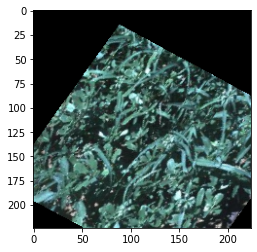

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rescale=1/255,rotation_range=45,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="constant")
aug_data = aug.flow(X_train, y_train)


x_batch, y_batch = next(aug_data)

for i in range(len(x_batch)):
    image = x_batch[i]
    plt.imshow(image)
    label = np.argmax(y_batch[i])
    print(dict_classes[label],i)
    plt.show()
    break

Bu aşamada ise doğrulama verilerini de artırımı sağlanarak test edilecek verinin artırılması planlanmıştır. Bunu yapmamızın sebebi eğitimdeki veriyle doğrulama verilerinin birbirine yakın veriler olması gerekmektedir yoksa başarı oranını etkiler.

Negative 0


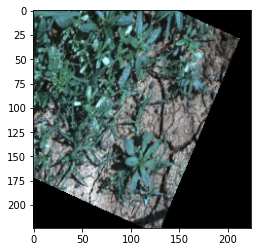

In [ ]:
aug = ImageDataGenerator(rescale=1/255,rotation_range=45,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="constant")
val_aug = aug.flow(X_val, y_val)

x_batch, y_batch = next(val_aug)

for i in range(len(x_batch)):
    image = x_batch[i]
    plt.imshow(image)
    label = np.argmax(y_batch[i])
    print(dict_classes[label],i)
    plt.show()
    break

## Modelin Oluşturulması

Başlıkta da verildiği gibi Resnet50 ve InceptionV3 modellerinin alınması ve eğitilmesi gerekmektedir. 

*Öncelikle modeli alıp hemen arkasından eğitime geçilmiştir*

### Resnet50 Modeli



# Görüntü Tanıma İçin Derin Artık Öğrenme(Deep Residual Learning)

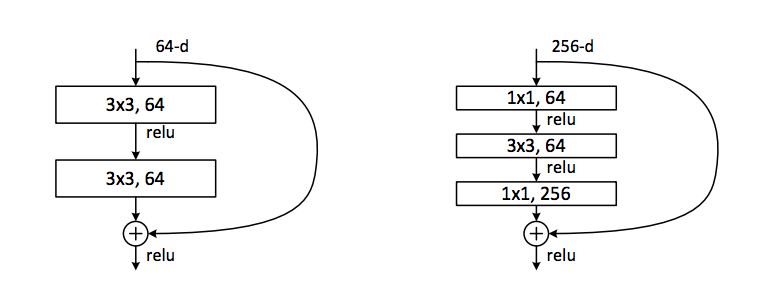

Son yıllarda bilgisayarlı görü alanı yeni teknolojilerin yayınlanmasıyla çeşitli dönüşümler geçirdi. Bu dönüşümlerin doğal bir sonucu olarak bilgisayarlı görü modellerinin nesne tanıma, yüz tanıma, görüntü sınıflandırma vb. gibi problemleri çözmesi insanlardan daha iyi bir seviyeye gelmiş oldu.

CNN'ler bilgisayarlı görü problemlerini çözmede oldukça başarılıdırlar fakat problem zorlaştıkça daha fazla katmana ihtiyaç duyarlar ve eğitilmeleri oldukça zorlaşabilir. İşte bu noktada ResNet devreye girmektedir. ResNet ile çok derin sinir ağlarını eğitmek mümkün hale gelmektedir.

**ResNet50 Nedir?**

ResNet'in aynı konsept üstünde çalışan fakat farklı katmanlara sahip çeşitleri bulunmaktadır. ResNet50 50 sinir ağı katmanıyla çalışan bir modeli belirtmek için kullanılır.

**ResNet Yapısı**

ResNet ağ derinleştikçe oluşan bozulmayı engellemek için katmanlar arasına kısayollar ekler. Ek olarak daha hızlı eğitim yapabilmek için darboğaz blokları kullanılır. ResNet modeli (1x1), (3x3), (1x1) şeklinde evrişim ağları kullanır.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Resnet50 Modeli Alınır, Ağırlıklar imagenet olarak ve alt katmanları dahil etmiyoruz. Boyutu görselin boyutlarına eş olmaktadır.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
#Model Çıktılarını alıyoruz.
x = base_model.output
# Global Average Pooling Katmanı Eklenmiştir.
x = GlobalAveragePooling2D(name='avg_pool')(x)
# Çoklu sınıflandırma için sigmoid aktivasyonu alınarak eklenmiştir.
outputs = Dense(9, activation='sigmoid', name='fc9')(x)
# Alınan modeller birleştirildi.
model = Model(inputs=base_model.input, outputs=outputs)
# Modelin katman bilgileri gösterildi.
model.summary()
# Keras callback özellikleri verilir.
# Early Stopping - Aşırı uydurmadan kaçınmak için regülarizasyon yöntemidir.
# ReduceLROnPlateau - Bir metrik öğrenmeyi durdurduğunda öğrenme katsayısını kısıtlar
early_stopping = EarlyStopping(patience=32, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=16, min_lr=0.000003125)
# Model derlendi.
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['categorical_accuracy'])

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model oluşturulduktan sonra eğitim durumuna göre erkenden bitirmesini ve ezberlemenin önüne geçilmesi için iki callback nesnesi veriyoruz. Bu verilerden sonra loss değeri için binary_crossentropy, optimizasyon olarak Adam optimizasyonu ve metrik olarak categorical_accuracy değerlerini verip derledikten sonra modeli 100 EPOCHS değeri ile 32 BATCH SIZE değerleri verecek 53 aşamada bir döngü tamamlaması sağlanmıştır ve doğrulama verileri de verilmiştir.

Model saate ve tarihe göre verilen isim doğrultusunda h5 formatında kaydedilecektir.

In [ ]:
# Model eğitime bşlar
history = model.fit(aug_data,validation_data=val_aug,batch_size=32,epochs=100,callbacks=(early_stopping,reduce_lr))

# Modelin düzenli kaydedilmesi için tarih ve saat alınır ve model kaydedilir.
from datetime import datetime
now = datetime.now()

save_date  = now.strftime("%Y-%d-%m - %H:%M")
model_name = "resnet50_model.h5"
save_name = f"{save_date} - {model_name}"
resnet_save_path = os.path.join(DATASET_FOLDER,'models',save_name)


model.save(resnet_save_path)
del model

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model eğitiminden sonra modelin kayıp ve başarı değerlerini alıyoruz ve bunları daha anlaşılır hale getirmek için matplotlib kütüphanesi ile pyplot modülü ile görsel olarak bastırılması planlanmıştır.

Metod history değerini alarak 2 tane grafik verecektir.

Bir sonraki kod bloğunda çağırılmaktadır.

In [ ]:
# Model geçmiş bilgisini grafik olarak alacağımız metod
def draw_history_plot(history):
  accuracy = history.history['categorical_accuracy']
  loss = history.history['loss']
  val_accuracy = history.history['val_categorical_accuracy']
  val_loss = history.history['val_loss']

  fig = plt.figure()
  plt.plot(accuracy,label='BAŞARILAR')
  plt.plot(val_accuracy,label='DOĞRULAMA BAŞARI')
  fig.suptitle('BAŞARI')
  plt.xlabel('EPOCH Sayısı')
  plt.ylabel('Değerler')
  plt.legend(['Başarı','Doğrulama'],loc='lower right')
  plt.show()

  fig = plt.figure()
  plt.plot(loss,label="KAYIP")
  plt.plot(val_loss,label='DOĞRULAMA KAYIP')
  fig.suptitle('KAYIPLAR')
  plt.xlabel('EPOCH Sayısı')
  plt.ylabel('Değerler')
  plt.legend(['Kayıp','Doğrulama'],loc='upper right')
  plt.show()

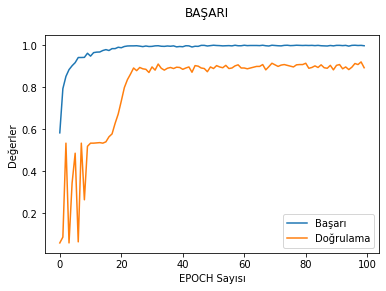

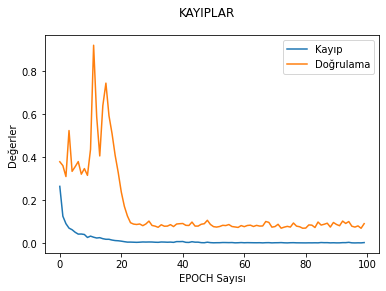

In [ ]:
draw_history_plot(history)

### InterceptionV3 Modeli

# INCEPTION V3
Bu ağ modeli modüllerden oluşmaktadır. Her modül, farklı boyuttaki evrişim ve max pooling işlemlerinden meydana gelir. Aşağıdaki görüntüde 3 evrişim ve 1 max pooling işlemi sonucunda 28x28x256 boyutlu bir tensör elde edilmiştir. Model her evrişim katmanından önce (1x1) evrişim katmanı kullanarak işlem yükünü optimize etmeye çalışır ve daha karmaşık ağlar için daha az hesap ve daha hızlı bir tasarım yapılabilmektedir. Bu (1x1) evrişim işlemine darboğaz(bottleneck) adı vermişlerdir.

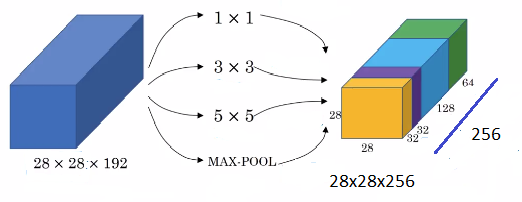

**Inception V3**
Inception Net v3, Inception v2'deki tüm yükseltmeleri içermekle birlikte ek olarak şu niteliklere sahiptir:


*   RMSProp optimize edicisi
*   Faktörize 7x7 evrişim ağları
*   Yardımcı sınıflandırıcılarda BatchNorm
*   LabelSmoothing (Ağın bir sınıf hakkında aşırı güven duymasını önleyen kayıp formülüne eklenen bir tür düzenleyici bileşen, aşırı öğrenmenin önüne geçer)





In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# InceptionV3 modeli eklenir. Imagenet ağırlıkları alınır ve alt katmanlar alınmaz. Resim katmanları verildi.
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
# Katman çıktları alındı.
x = base_model.output
# Global Average Pooling Eklendi.
x = GlobalAveragePooling2D(name='avg_pool')(x)
# Çoklu sınıflandırma için sigmoid aktivasyonu kullanarak tam bağlı katmanlar oluşturuldu.
outputs = Dense(9, activation='sigmoid', name='fc9')(x)
# Model Oluşturulur.
model = Model(inputs=base_model.input, outputs=outputs)
# Model katmanları yazdırılır.
model.summary()
# Keras callback özellikleri verilir.
# Early Stopping - Aşırı uydurmadan kaçınmak için regülarizasyon yöntemidir.
# ReduceLROnPlateau - Bir metrik öğrenmeyi durdurduğunda öğrenme katsayısını kısıtlar
early_stopping = EarlyStopping(patience=32, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=16, min_lr=0.000003125)
# Model Derlenir.
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['categorical_accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model oluşturulduktan sonra eğitim durumuna göre erkenden bitirmesini ve ezberlemenin önüne geçilmesi için iki callback nesnesi veriyoruz. Bu verilerden sonra loss değeri için binary_crossentropy, optimizasyon olarak Adam optimizasyonu ve metrik olarak categorical_accuracy değerlerini verip derledikten sonra modeli 100 EPOCHS değeri ile 32 BATCH SIZE değerleri verecek 53 aşamada bir döngü tamamlaması sağlanmıştır ve doğrulama verileri de verilmiştir.

Model saate ve tarihe göre verilen isim doğrultusunda h5 formatında kaydedilecektir.

Bir sonraki kod bloğunda ise grafik için verdiğimiz metodu çağıracaktır.

In [ ]:
# Model Eğitime Başlar.
# Kaydedileceği konumu ayarlar.
history_2 = model.fit(aug_data,validation_data=val_aug,batch_size=32,epochs=100,callbacks=(early_stopping,reduce_lr))

now = datetime.now()

save_date  = now.strftime("%Y-%d-%m - %H:%M")
model_name = "inceptionv3_model.h5"
save_name = f"{save_date} - {model_name}"
inception_save_path = os.path.join(DATASET_FOLDER,'models',save_name)


model.save(inception_save_path)
del model

Epoch 1/100
53/53 [==============================] - 35s 560ms/step - loss: 0.2648 - categorical_accuracy: 0.5582 - val_loss: 0.3366 - val_categorical_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 2/100
53/53 [==============================] - 29s 540ms/step - loss: 0.1253 - categorical_accuracy: 0.7809 - val_loss: 0.3115 - val_categorical_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 3/100
53/53 [==============================] - 29s 538ms/step - loss: 0.0922 - categorical_accuracy: 0.8436 - val_loss: 0.3239 - val_categorical_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 4/100
53/53 [==============================] - 29s 541ms/step - loss: 0.0709 - categorical_accuracy: 0.8949 - val_loss: 0.3327 - val_categorical_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 5/100
53/53 [==============================] - 29s 541ms/step - loss: 0.0633 - categorical_accuracy: 0.9015 - val_loss: 0.3292 - val_categorical_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 6/100
53/53 [==============================] - 29s 544ms/step - loss:

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


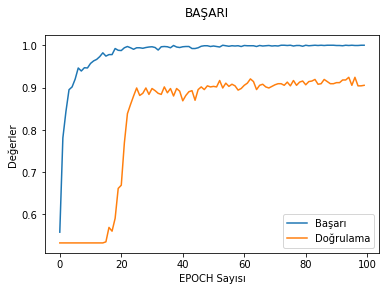

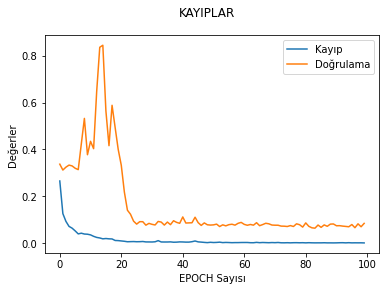

In [ ]:
draw_history_plot(history_2)

## Modellerin Testi

Eğitilen modellerin testi için evulate metodu ile kullanılması da mümkündür fakat bize sadece kayıp ve başarı değerlerini verecektir. Bu aşamada ise biz verimizin etiketinin ne olduğunu ve iki modelin de ne olarak tahmin ettiğini göreceğimiz ve bunlara da skot tutabileceğimiz bir algoritma yer almaktadır.

In [ ]:
from tensorflow.keras.models import load_model

resnet_model = load_model(resnet_save_path)
inception_model = load_model(inception_save_path)

total_test = len(X_test)

resnet_test_score = 0
inception_test_score = 0


for index,test_image in enumerate(X_test):
  img_test = np.reshape(test_image,(1,224,224,3))/255

  pred_resnet = resnet_model.predict(img_test)
  pred_inception = inception_model.predict(img_test)

  pred_result_resnet = np.argmax(pred_resnet)
  pred_result_inception = np.argmax(pred_inception)

  test_result = np.argmax(y_test[index])

  print(f"""
  Resnet50 Predict : {dict_classes[pred_result_resnet]}
  inceptionV3 Predict : {dict_classes[pred_result_inception]}
  Test : {dict_classes[test_result]}
  """)

  if pred_result_resnet == test_result:
    resnet_test_score += 1
  if pred_result_inception == test_result:
    inception_test_score += 1
print(f"""
------------------------------------------------------------
Test Tamamlandı.
Test Sayısı       : {total_test}
------------------------------------------------------------
Resnet50
Test Doğru Sayı   : {resnet_test_score}
Test Skoru        : {round((resnet_test_score/total_test)*100,2)} %
------------------------------------------------------------
Inception
Test Doğru Sayısı : {inception_test_score}
Test Skoru        : {round((inception_test_score/total_test)*100,2)} %
------------------------------------------------------------
""")



  Resnet50 Predict : Rubber vine
  inceptionV3 Predict : Rubber vine
  Test : Rubber vine
  

  Resnet50 Predict : Prickly acacia
  inceptionV3 Predict : Prickly acacia
  Test : Prickly acacia
  

  Resnet50 Predict : Negative
  inceptionV3 Predict : Negative
  Test : Negative
  

  Resnet50 Predict : Negative
  inceptionV3 Predict : Lantana
  Test : Lantana
  

  Resnet50 Predict : Negative
  inceptionV3 Predict : Negative
  Test : Negative
  

  Resnet50 Predict : Negative
  inceptionV3 Predict : Negative
  Test : Negative
  

  Resnet50 Predict : Negative
  inceptionV3 Predict : Negative
  Test : Negative
  

  Resnet50 Predict : Negative
  inceptionV3 Predict : Negative
  Test : Negative
  

  Resnet50 Predict : Negative
  inceptionV3 Predict : Negative
  Test : Negative
  

  Resnet50 Predict : Prickly acacia
  inceptionV3 Predict : Parthenium
  Test : Parkinsonia
  

  Resnet50 Predict : Chinee apple
  inceptionV3 Predict : Negative
  Test : Chinee apple
  

  Resnet50 Predict :

*Sonuncu* olarak eğitim sonrası elde ettiğimiz bilgileri yani history bilgilerini json kütüphanesi yardımıyla models içerisindeki bir dosyaya yazıyoruz.

In [ ]:
import json

with open(resnet_save_path+'.json','w') as files:
  json.dump(str(history.history),files)
  files.close()

with open(inception_save_path+'.json','w') as files:
  json.dump(str(history_2.history),files)
  files.close()